# 📊 IEG Outcome Ratings and M&E Quality Analysis (2015–2025)

This notebook presents summary statistics and visualizations for World Bank projects evaluated by the Independent Evaluation Group (IEG) between 2015 and 2025. The focus is on projects in the Human Development Practice Group.

We answer the following questions:
1. How do Outcome Ratings vary by region?
2. What is the relationship between Monitoring and Evaluation (M&E) Quality and Outcome Ratings?

The analysis includes:
- Data filtering and preprocessing
- Regional distribution of outcome ratings
- Geographic visualization of average outcome scores
- Relationship between M&E Quality and project outcomes


## 1. Setup and Data Loading
Load required packages and filter the data to include only projects approved between 2015 and 2025 in the Human Development group.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium
import os

# Set working directories
cwd = os.getcwd()
data_dir = os.path.join(os.path.dirname(cwd), '1_Data')

# Output directory:
output = os.path.join(os.path.dirname(cwd), '3_Outputs')
output = "C:\\Users\\wb592581\\Documents\\"

# Load IEG Ratings dataset
data_path = os.path.join(data_dir, 'IEG_ICRR_PPAR_Ratings_2025-03-12.xlsx')
df = pd.read_excel(data_path)

# Filter data: Projects approved between 2015–2025 and mapped to Human Development
df = df[
    (df['Approval FY'].between(2015, 2025)) &
    (df['Practice Group'] == 'HD')
].copy()

## 2. Outcome Ratings by Region
Generate a stacked bar chart to show the distribution of Outcome Ratings across regions.

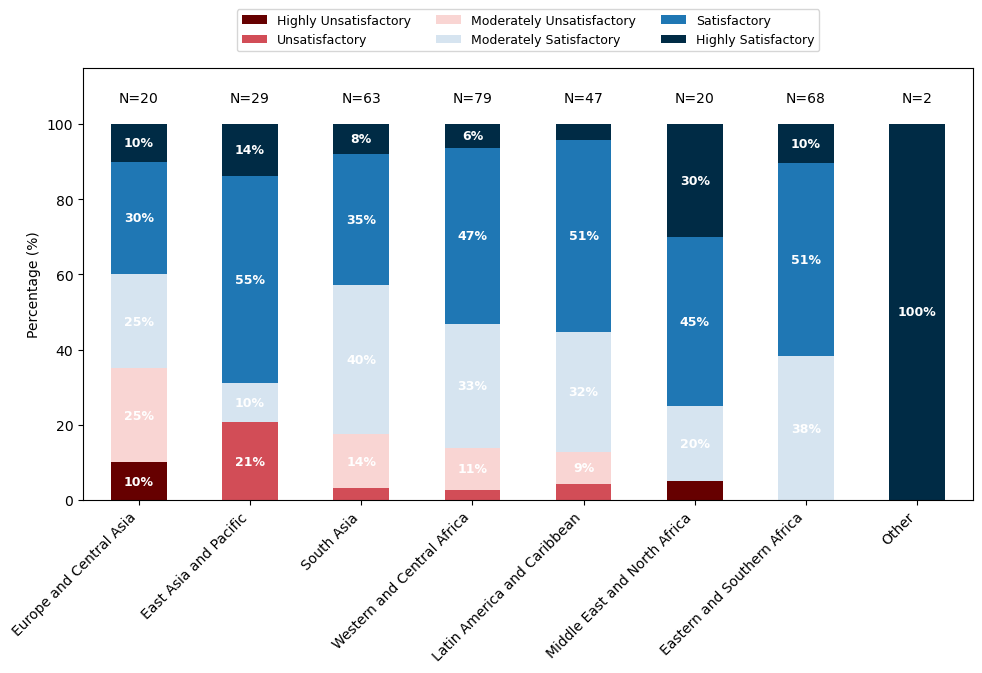

In [2]:
# Define rating order and color palette
rating_order = [
    'Highly Satisfactory', 'Satisfactory', 'Moderately Satisfactory',
    'Moderately Unsatisfactory', 'Unsatisfactory', 'Highly Unsatisfactory'
]
rating_colors = {
    'Highly Satisfactory': '#002b45', 'Satisfactory': '#1f77b4',
    'Moderately Satisfactory': '#d6e4f0', 'Moderately Unsatisfactory': '#f9d5d3',
    'Unsatisfactory': '#d24d57', 'Highly Unsatisfactory': '#660000'
}

# Compute rating counts and proportions
rating_counts = pd.crosstab(df['Region'], df['IEG Outcome Ratings'])
rating_counts = rating_counts.reindex(columns=rating_order, fill_value=0)
rating_percentages = rating_counts.div(rating_counts.sum(axis=1), axis=0) * 100

# Sort regions by share of negative ratings
sorted_regions = rating_percentages[
    ['Moderately Unsatisfactory', 'Unsatisfactory', 'Highly Unsatisfactory']
].sum(axis=1).sort_values(ascending=False).index

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(10, 7))
rating_percentages.loc[sorted_regions][rating_order[::-1]].plot(
    kind='bar', stacked=True, color=[rating_colors[r] for r in rating_order[::-1]], ax=ax
)

# Add percentage and sample size labels
for i, region in enumerate(sorted_regions):
    bottom = 0
    for rating in rating_order[::-1]:
        val = rating_percentages.loc[region, rating]
        if val > 5:
            ax.text(i, bottom + val/2, f'{val:.0f}%', ha='center', va='center', color='white', fontsize=9, fontweight='bold')
        bottom += val
    total = rating_counts.loc[region].sum()
    ax.text(i, 105, f'N={total}', ha='center', va='bottom', fontsize=10)

# Styling
ax.set_ylabel('Percentage (%)')
ax.set_xlabel('')
ax.set_ylim(0, 115)
ax.set_xticklabels(sorted_regions, rotation=45, ha='right')
ax.legend(title='', loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, fontsize=9)
plt.title('')
plt.tight_layout()
plt.savefig(output + "stacked_bar_outcome_regions.png", dpi=300) 
plt.show()

## 3. Geographic Distribution of Outcome Scores
Create an interactive Folium map to visualize average Outcome Scores by country.

In [3]:
# Numeric mapping for Outcome ratings
rating_map = {
    'Highly Satisfactory': 6, 'Satisfactory': 5, 'Moderately Satisfactory': 4,
    'Moderately Unsatisfactory': 3, 'Unsatisfactory': 2, 'Highly Unsatisfactory': 1
}
df['IEG_Outcome_Score'] = df['IEG Outcome Ratings'].map(rating_map)

# Average score and sample size by country
summary = df.groupby('Country').agg(
    IEG_Outcome_Score_Mean=('IEG_Outcome_Score', 'mean'),
    Num_Observations=('IEG_Outcome_Score', 'count')
).reset_index()

# Load shapefile
shp_path = os.path.join(data_dir, 'shapefiles', 'ne_110m_admin_0_countries.shp')
gdf = gpd.read_file(shp_path).rename(columns={'ADMIN': 'Country'})

# Harmonize country names
country_rename = {
    "Republic of the Congo": "Congo",
    "Democratic Republic of the Congo": "Congo, Democratic Republic of",
    "Ivory Coast": "Cote d'Ivoire",
    "Laos": "Lao PDR",
    "United Republic of Tanzania": "Tanzania",
    "Gambia": "The Gambia",
    "Turkey": "Turkiye",
    "Vietnam": "Viet Nam"
}
gdf['Country'] = gdf['Country'].replace(country_rename)

# Merge and filter
gdf = gdf.merge(summary, on='Country', how='left')
gdf = gdf[gdf['Country'] != 'Antarctica']

# Generate popups
def popup_text(row):
    text = f"{row['Country']}<br>"
    text += f"Mean: {row['IEG_Outcome_Score_Mean']:.2f}<br>" if pd.notnull(row['IEG_Outcome_Score_Mean']) else "Mean: No Data<br>"
    text += f"N = {int(row['Num_Observations'])}" if pd.notnull(row['Num_Observations']) else "N = No Data"
    return text

gdf['popup_text'] = gdf.apply(popup_text, axis=1)

# Create map
m = folium.Map(location=[0, 0], zoom_start=2)
folium.Choropleth(
    geo_data=gdf,
    data=gdf,
    columns=['Country', 'IEG_Outcome_Score_Mean'],
    key_on='feature.properties.Country',
    fill_color='YlOrRd_r',
    fill_opacity=0.7,
    line_opacity=0.2,
    nan_fill_color="lightgray",
    legend_name='Average Outcome Score'
).add_to(m)

folium.GeoJson(
    gdf,
    tooltip=folium.GeoJsonTooltip(fields=['popup_text'], labels=False, sticky=True),
    style_function=lambda x: {'color': 'black', 'weight': 0.5, 'fillOpacity': 0.0}
).add_to(m)

m.fit_bounds([[-40, -100], [40, 120]])
m.save(output + "interactive_map.html")

## 4. Relationship Between M&E Quality and Outcome Ratings (Stacked Bar Chart)
Create a stacked bar chart showing the relationship between the outcome rating and M&E.

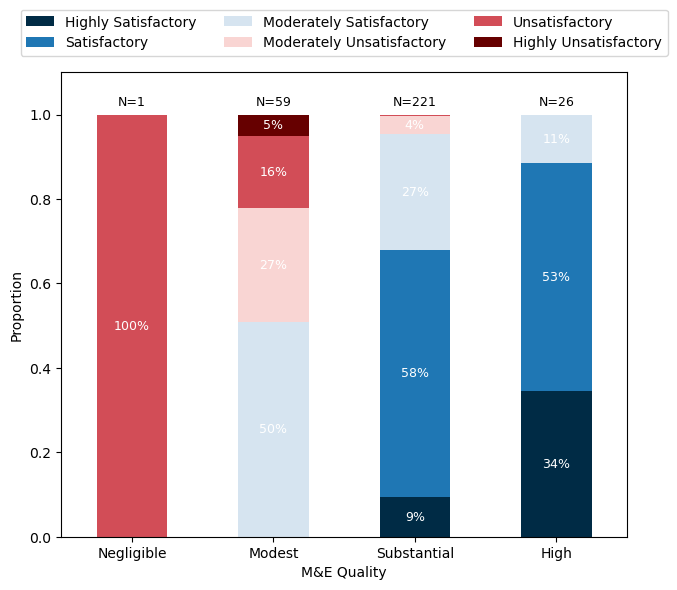

In [4]:
# Define categorical order
me_order = ['Negligible', 'Modest', 'Substantial', 'High']
df['IEG Monitoring and Evaluation Quality Ratings'] = pd.Categorical(df['IEG Monitoring and Evaluation Quality Ratings'], categories=me_order, ordered=True)
df['IEG Outcome Ratings'] = pd.Categorical(df['IEG Outcome Ratings'], categories=rating_order, ordered=True)

# Compute contingency table
proportions = pd.crosstab(
    df['IEG Monitoring and Evaluation Quality Ratings'],
    df['IEG Outcome Ratings'],
    normalize='index'
)
counts = pd.crosstab(
    df['IEG Monitoring and Evaluation Quality Ratings'],
    df['IEG Outcome Ratings']
)

# Plot
fig, ax = plt.subplots(figsize=(7, 6))
proportions[rating_order].plot(kind='bar', stacked=True, color=[rating_colors[r] for r in rating_order], ax=ax)

x_labels = proportions.index.tolist()
x_pos = range(len(x_labels))

# Add percentages and sample sizes
for idx, i in enumerate(x_labels):
    row = proportions.loc[i]
    bottom = 0
    for rating in rating_order:
        val = row[rating]
        if val > 0.03:
            ax.text(x_pos[idx], bottom + val / 2, f"{int(val * 100)}%", ha='center', va='center', color='white', fontsize=9)
        bottom += val
    ax.text(x_pos[idx], 1.02, f"N={int(counts.loc[i].sum())}", ha='center', fontsize=9)

# Styling
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels)
ax.set_ylabel("Proportion")
ax.set_xlabel("M&E Quality")
ax.set_ylim(0, 1.1)
plt.xticks(rotation=0)
plt.legend(title='', loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)
plt.title('')
plt.tight_layout()
plt.savefig(output + "stacked_bar_outcome_vs_ME.png", dpi=300) 
plt.show()

## 5. Outcome Score by M&E Quality (Boxplot)
Create a boxplot showing the relationship between the outcome rating and M&E

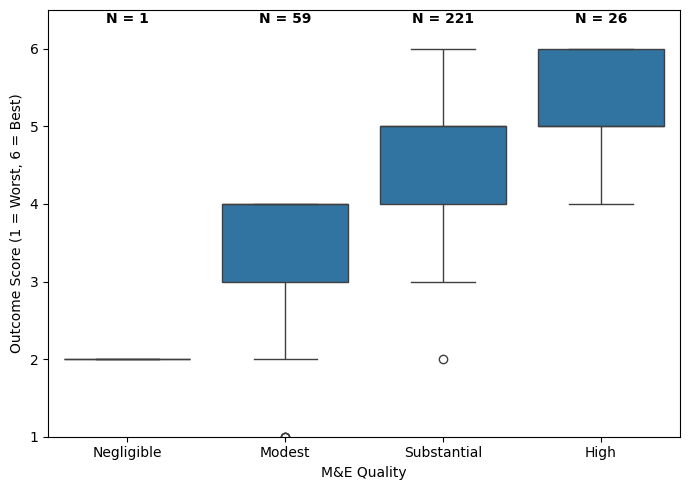

In [5]:
group_counts = df['IEG Monitoring and Evaluation Quality Ratings'].value_counts().reindex(me_order)

plt.figure(figsize=(7, 5))
ax = sns.boxplot(
    x='IEG Monitoring and Evaluation Quality Ratings',
    y='IEG_Outcome_Score',
    data=df,
    order=me_order
)

y_max = df['IEG_Outcome_Score'].max() + 0.3  
for i, group in enumerate(me_order):
    count = group_counts.get(group)
    if count:
        ax.text(i, y_max, f'N = {count}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.ylabel("Outcome Score (1 = Worst, 6 = Best)")
plt.xlabel("M&E Quality")
plt.title("")
plt.ylim(1, 6.5)  
plt.tight_layout()

plt.savefig(output + "boxplot_outcome_by_ME_quality.png", dpi=300) 
plt.show()
